# Inverse Navier-Stokes Problem

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/en/physics_driven/mindspore_navier_stokes_inverse.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/en/physics_driven/mindspore_navier_stokes_inverse.py)&emsp;[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/r2.5.0/docs/mindflow/docs/source_en/physics_driven/navier_stokes_inverse.ipynb)

This notebook requires **MindSpore version >= 2.0.0** to support new APIs including: *mindspore.jit, mindspore.jit_class, mindspore.jacrev*.

## Overview

The Navier-Stokes equations are a set of partial differential equations describing the variation of fluid velocity and pressure in fluid mechanics.The inverse problem of Navier-Stokes is that of solving the fluid properties (e.g., viscosity, density, etc.) and fluid boundary conditions (e.g., wall friction, etc.) that can produce certain fluid motion characteristics (e.g., flow rate, velocity, etc.), given that these characteristics are known Problem. Unlike the positive problem (i.e., the fluid properties and boundary conditions are known and the kinematic characteristics of the fluid are solved), the solution of the inverse problem needs to be solved by numerical optimization and inverse extrapolation methods.

The inverse problem of Navier-Stokes has a wide range of applications in engineering and scientific computing, for example, in the fields of aviation, energy, geology, and biology, where it can be used to optimize fluid design, predict fluid motion, diagnose fluid problems, and so on. Although the inverse problem of Navier-Stokes is very challenging, some progress has been made in recent years with the development of computer technology and numerical methods. For example, the solution process of the inverse problem can be accelerated and the solution accuracy can be improved by using techniques such as high-performance computing and machine learning-based inverse projection methods.

## Problem Description

In inverse Navier-Stokes problem, two parameters remain unknown, which is different from Navier-Stokes equation. The inverse Navier-Stokes problem has the following form:

$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$

$$
\frac{\partial u} {\partial t} + \theta_1 (u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y}) = - \frac{\partial p}{\partial x} + \theta_2 (\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2})
$$

$$
\frac{\partial v} {\partial t} + \theta_1 (u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}) = - \frac{\partial p}{\partial y} + \theta_2 (\frac{\partial^2v}{\partial x^2} + \frac{\partial^2v}{\partial y^2})
$$

where $\theta_1$ and $\theta_2$ are the unknown parameters.

In this case, the PINNs method is used to learn the mapping from the location and time to flow field quantities to solve the parameters .

## Technology Path

MindSpore Flow solves the problem as follows:

1. Training Dataset Construction.
2. Model Construction.
3. Optimizer.
4. InvNavierStokes.
5. Model Training.
6. Model Evaluation and Visualization.

In [1]:
import time

import numpy as np

import mindspore
from mindspore import context, nn, ops, jit, set_seed, load_checkpoint, load_param_into_net

The following `src` package can be downloaded in [applications/physics_driven/navier_stokes/cylinder_flow_inverse/src](https://gitee.com/mindspore/mindscience/tree/r0.7/MindFlow/applications/physics_driven/navier_stokes/cylinder_flow_inverse/src)

In [2]:
from mindflow.cell import MultiScaleFCSequential
from mindflow.utils import load_yaml_config
from mindflow.pde import sympy_to_mindspore, PDEWithLoss
from mindflow.loss import get_loss_metric

from src import create_training_dataset, create_test_dataset, calculate_l2_error

set_seed(123456)
np.random.seed(123456)

The following `inverse_navier_stokes.yaml` can be downloaded in [applications/physics_driven/navier_stokes/cylinder_flow_inverse/configs/navier_stokes_inverse.yaml](https://gitee.com/mindspore/mindscience/blob/r0.7/MindFlow/applications/physics_driven/navier_stokes/cylinder_flow_inverse/configs/navier_stokes_inverse.yaml)

In [3]:
# set context for training: using graph mode for high performance training with GPU acceleration
config = load_yaml_config('inverse_navier_stokes.yaml')
context.set_context(mode=context.GRAPH_MODE, device_target="GPU", device_id=0)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"

## Training Dataset Construction

In this case, training data and test data are sampled from [raw data](https://github.com/maziarraissi/PINNs/blob/master/main/Data/cylinder_nektar_wake.mat).

Download the training and test dataset: [physics_driven/inverse_navier_stokes/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/physics_driven/inverse_navier_stokes/dataset).

In [4]:
# create dataset
inv_ns_train_dataset = create_training_dataset(config)
train_dataset = inv_ns_train_dataset.create_dataset(batch_size=config["train_batch_size"],
                                                    shuffle=True,
                                                    prebatched_data=True,
                                                    drop_remainder=True)
# create  test dataset
inputs, label = create_test_dataset(config)

./inverse_navier_stokes/dataset
get dataset path: ./inverse_navier_stokes/dataset
check eval dataset length: (40, 100, 50, 3)


## Model Construction

This example uses a simple fully-connected network with a depth of 6 layers and the activation function is the `tanh` function, each layer has 20 neurons.

In [5]:
coord_min = np.array(config["geometry"]["coord_min"] + [config["geometry"]["time_min"]]).astype(np.float32)
coord_max = np.array(config["geometry"]["coord_max"] + [config["geometry"]["time_max"]]).astype(np.float32)
input_center = list(0.5 * (coord_max + coord_min))
input_scale = list(2.0 / (coord_max - coord_min))

model = MultiScaleFCSequential(in_channels=config["model"]["in_channels"],
                               out_channels=config["model"]["out_channels"],
                               layers=config["model"]["layers"],
                               neurons=config["model"]["neurons"],
                               residual=config["model"]["residual"],
                               act='tanh',
                               num_scales=1,
                               input_scale=input_scale,
                               input_center=input_center)

## Optimizer

When constructing Optimizer, the two unknown parameters are added into the Optimizer, along with the parameters from the model.

In [6]:
if config["load_ckpt"]:
    param_dict = load_checkpoint(config["load_ckpt_path"])
    load_param_into_net(model, param_dict)

theta = mindspore.Parameter(mindspore.Tensor(np.array([0.0, 0.0]).astype(np.float32)), name="theta", requires_grad=True)
params = model.trainable_params()
params.append(theta)
optimizer = nn.Adam(params, learning_rate=config["optimizer"]["initial_lr"])

## InvNavierStokes

The following `inverse NavierStokes` defines the navier-stokes inverse problem. Specifically, it includes 2 parts: governing equation and train loss.

In [1]:
from sympy import diff, Function, symbols
from mindspore import numpy as mnp

class InvNavierStokes(PDEWithLoss):
    r"""
    2D inverse NavierStokes equation problem based on PDEWithLoss.

    Args:
        model (mindspore.nn.Cell): network for training.
        params(mindspore.Tensor): parameter needs training
        loss_fn (Union[str, Cell]): Define the loss function. Default: mse.

    Supported Platforms:
        ``Ascend`` ``GPU``
    """

    def __init__(self, model, params, loss_fn="mse"):

        self.params_val = params[-1]
        self.theta1, self.theta2 = symbols('theta1 theta2')
        self.x, self.y, self.t = symbols('x y t')
        self.u = Function('u')(self.x, self.y, self.t)
        self.v = Function('v')(self.x, self.y, self.t)
        self.p = Function('p')(self.x, self.y, self.t)

        self.in_vars = [self.x, self.y, self.t]
        self.out_vars = [self.u, self.v, self.p]
        self.params = [self.theta1, self.theta2]

        super(InvNavierStokes, self).__init__(model, self.in_vars, self.out_vars, self.params, self.params_val)
        self.data_nodes = sympy_to_mindspore(self.data_loss(), self.in_vars, self.out_vars)
        if isinstance(loss_fn, str):
            self.loss_fn = get_loss_metric(loss_fn)
        else:
            self.loss_fn = loss_fn

    def pde(self):
        """
        Define governing equations based on sympy, abstract method.

        Returns:
            dict, user defined sympy symbolic equations.
        """
        momentum_x = self.u.diff(self.t) + \
                     self.theta1 * (self.u * self.u.diff(self.x) + self.v * self.u.diff(self.y)) + \
                     self.p.diff(self.x) - \
                     self.theta2 * (diff(self.u, (self.x, 2)) + diff(self.u, (self.y, 2)))
        momentum_y = self.v.diff(self.t) + \
                     self.theta1 * (self.u * self.v.diff(self.x) + self.v * self.v.diff(self.y)) + \
                     self.p.diff(self.y) - \
                     self.theta2 * (diff(self.v, (self.x, 2)) + diff(self.v, (self.y, 2)))
        continuty = self.u.diff(self.x) + self.v.diff(self.y)

        equations = {"momentum_x": momentum_x, "momentum_y": momentum_y, "continuty": continuty}
        return equations

    def data_loss(self):
        """
        Define governing equations based on sympy, abstract method.

        Returns:
            dict, user defined sympy symbolic equations.
        """
        velocity_u = self.u
        velocity_v = self.v
        p = self.p
        equations = {"velocity_u": velocity_u, "velocity_v": velocity_v, "p": p}
        return equations

    def get_loss(self, pde_data, data, label):
        """
        loss contains 2 parts,pde parts and data loss.
        """
        pde_res = self.parse_node(self.pde_nodes, inputs=pde_data)
        pde_residual = ops.Concat(1)(pde_res)
        pde_loss = self.loss_fn(pde_residual, mnp.zeros_like(pde_residual))

        data_res = self.parse_node(self.data_nodes, inputs=data)
        data_residual = ops.Concat(1)(data_res)
        train_data_loss = self.loss_fn(data_residual, label)

        return pde_loss + train_data_loss

## Model Training

With **MindSpore version >= 2.0.0**, we can use the functional programming for training neural networks.

In [8]:
def train():
    problem = InvNavierStokes(model, params)
    if use_ascend:
        from mindspore.amp import DynamicLossScaler, auto_mixed_precision, all_finite
        loss_scaler = DynamicLossScaler(1024, 2, 100)
        auto_mixed_precision(model, 'O3')

    def forward_fn(pde_data, train_points, train_label):
        loss = problem.get_loss(pde_data, train_points, train_label)
        if use_ascend:
            loss = loss_scaler.scale(loss)
        return loss

    grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

    @jit
    def train_step(pde_data, train_points, train_label):
        loss, grads = grad_fn(pde_data, train_points, train_label)
        if use_ascend:
            loss = loss_scaler.unscale(loss)
            if all_finite(grads):
                grads = loss_scaler.unscale(grads)
                loss = ops.depend(loss, optimizer(grads))
        else:
            loss = ops.depend(loss, optimizer(grads))
        return loss

    epochs = config["train_epochs"]
    steps_per_epochs = train_dataset.get_dataset_size()
    sink_process = mindspore.data_sink(train_step, train_dataset, sink_size=1)

    param1_hist = []
    param2_hist = []
    for epoch in range(1, 1 + epochs):
        # train
        time_beg = time.time()
        model.set_train(True)
        for _ in range(steps_per_epochs):
            step_train_loss = sink_process()
        print(f"epoch: {epoch} train loss: {step_train_loss} epoch time: {(time.time() - time_beg) * 1000 :.3f} ms")
        model.set_train(False)
        if epoch % config["eval_interval_epochs"] == 0:
            print(f"Params are{params[-1].value()}")
            param1_hist.append(params[-1].value()[0])
            param2_hist.append(params[-1].value()[1])
            calculate_l2_error(model, inputs, label, config)

In [9]:
start_time = time.time()
train()
print("End-to-End total time: {} s".format(time.time() - start_time))

momentum_x: theta1*u(x, y, t)*Derivative(u(x, y, t), x) + theta1*v(x, y, t)*Derivative(u(x, y, t), y) - theta2*Derivative(u(x, y, t), (x, 2)) - theta2*Derivative(u(x, y, t), (y, 2)) + Derivative(p(x, y, t), x) + Derivative(u(x, y, t), t)
    Item numbers of current derivative formula nodes: 6
momentum_y: theta1*u(x, y, t)*Derivative(v(x, y, t), x) + theta1*v(x, y, t)*Derivative(v(x, y, t), y) - theta2*Derivative(v(x, y, t), (x, 2)) - theta2*Derivative(v(x, y, t), (y, 2)) + Derivative(p(x, y, t), y) + Derivative(v(x, y, t), t)
    Item numbers of current derivative formula nodes: 6
continuty: Derivative(u(x, y, t), x) + Derivative(v(x, y, t), y)
    Item numbers of current derivative formula nodes: 2
velocity_u: u(x, y, t)
    Item numbers of current derivative formula nodes: 1
velocity_v: v(x, y, t)
    Item numbers of current derivative formula nodes: 1
p: p(x, y, t)
    Item numbers of current derivative formula nodes: 1
epoch: 100 train loss: 0.04028289 epoch time: 2229.404 ms
Param

## Model Evaluation and Visualization

After training, all data points in the flow field can be inferred. And related results can be visualized.

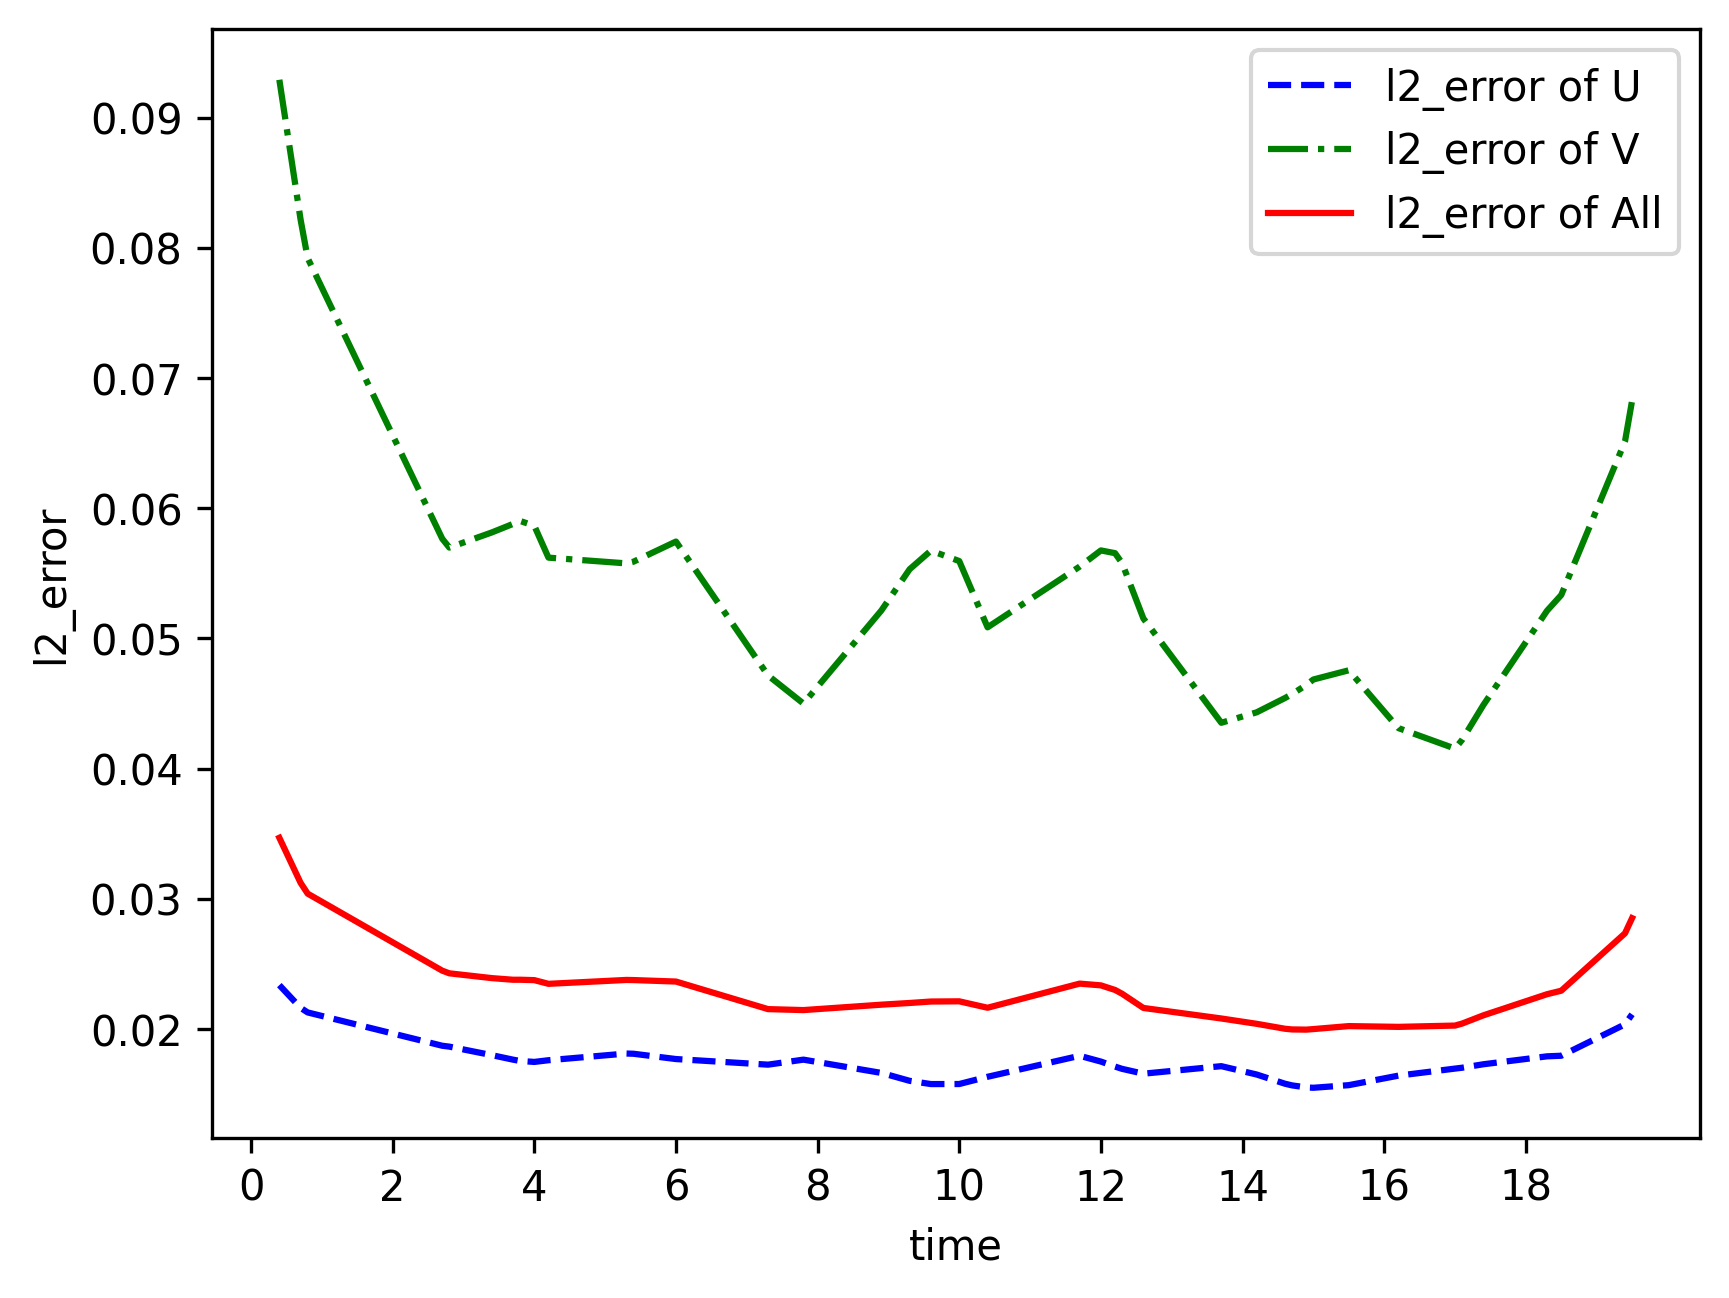

In [15]:
from src import visual

# visualization
visual(model=model, epochs=config["train_epochs"], input_data=inputs, label=label)


Text(0, 0.5, 'value')

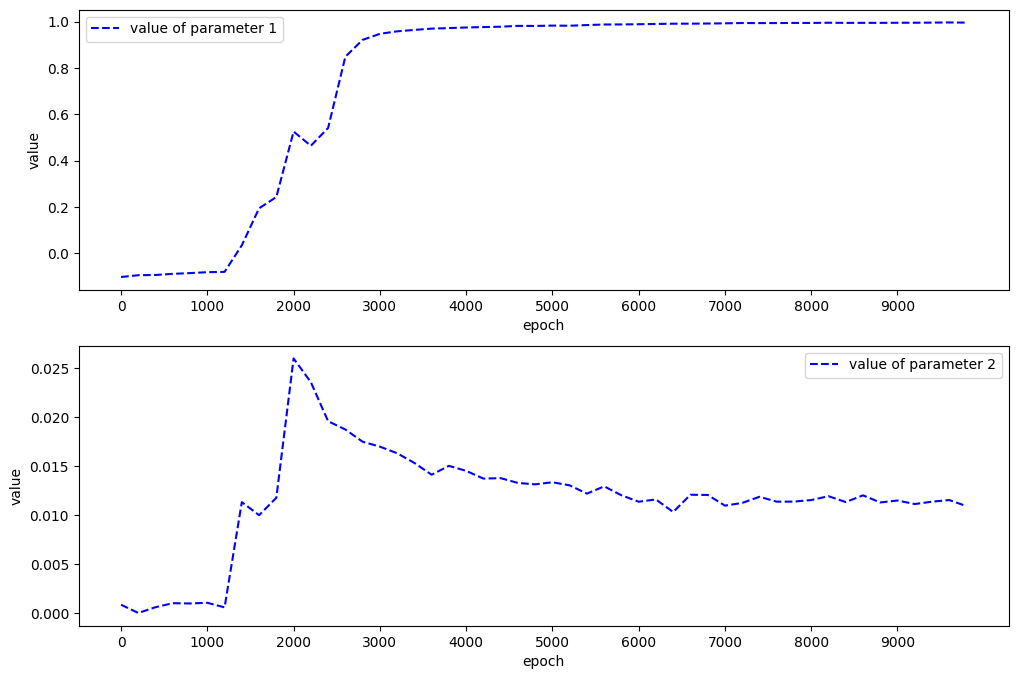

In [1]:
from src import plot_params

plot_params(param1_hist, param2_hist)

In this case, the standard value for $\theta_1$ and $\theta_2$ are 1 and 0.01, respectively.

Correct PDE:

- $u_t + (u u_x + v u_x) = - p_x + 0.01(u_{xx} + u_{yy})$

- $v_t + (u v_x + v v_x) = - p_y + 0.01(v_{xx} + v_{yy})$

Identified PDE:

- $u_t + 0.9984444(u u_x + v u_x) = - p_x + 0.01072927(u_{xx} + u_{yy})$

- $v_t + 0.9984444(u v_x + v v_x) = - p_y + 0.01072927(v_{xx} + v_{yy})$